### Imports

In [1]:
from pathlib import Path
import gym
import gym.spaces 
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from tqdm import tqdm
import datetime
import random
  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def set_seed(seed, env):
    env.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Wrappers

In [3]:
class NoopResetEnv(gym.Wrapper):
    """
    Realiza un número random de "NOOP" al invocar reset().
    """
    def __init__(self, env, noop_max=30):
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'
        
    def reset(self):
        self.env.reset()
        noops = self.env.unwrapped.np_random.integers(1, self.noop_max+1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset()
        return obs

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    """
    Salta un número de frames y regresa el valor promedio de cada pixel.
    """
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._skip = skip
        self._obs_buffer = np.zeros((self._skip,) + env.observation_space.shape, dtype=np.uint8)
        
    def step(self, action):
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, _, info = self.env.step(action)
            self._obs_buffer[i] = obs
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return obs

In [5]:
class TimeLimit(gym.Wrapper):
    """
    Termina el episodio después de un número de pasos.
    Evita que los ambientes entren en un loop o sin moverse.
    """
    def __init__(self, env, max_episode_steps=None):
        super(TimeLimit, self).__init__(env)
        self._max_episode_steps = max_episode_steps
        self._elapsed_steps = 0
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            done = True
            info['TimeLimit.truncated'] = True
        return obs, reward, done, info

    def reset(self):
        self._elapsed_steps = 0
        obs = self.env.reset()
        return obs
        

In [6]:
class FireResetEnv(gym.Wrapper):
    """
    Realiza la acción "FIRE" para iniciar los juegos que lo requieran.
    """
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = env.ale.lives()
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        #assert len(env.unwrapped.get_action_meanings()) >= 3
    
    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs
    
    def step(self, action):
        if self.lives > env.ale.lives():
            self.lives = env.ale.lives()
            action = 1
        obs, reward, done, info = self.env.step(action)
        return obs, reward, done, info

In [7]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_r=-1, max_r=1):
        super().__init__(env)
        self.min_r = min_r
        self.max_r = max_r
        
    def reward(self, reward):
        if reward < 0:
            return -1
        elif reward > 0:
            return 1
        else:
            return 0
        
    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        return obs, self.reward(rew), done, info

In [8]:
class WarpFrame(gym.ObservationWrapper):
    """
    Reescala las imágenes a 84x84 y las pasa de RGB a gris.
    """
    def __init__(self, env, width=84, height=84):
        super().__init__(env)
        self._width = width
        self._height = height
        num_colors = 1
        
        new_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (self._height, self._width, num_colors),
            dtype = np.uint8,
        )
        original_space = self.observation_space
        self.observation_space = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3
        
    def observation(self, obs):
        frame = obs
        frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        frame = cv.resize(
            frame, (self._width, self._height), interpolation=cv.INTER_AREA
        )
        obs = frame
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

In [9]:
class ScaledFloatFrame(gym.ObservationWrapper):
    """
    Reescala de 0-255 a 0-1.
    """
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = env.observation_space.shape,
            dtype = np.float32,
        )
    
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

In [10]:
class FrameStack(gym.Wrapper):
    """
    Apila los últimos k frames.
    """
    def __init__(self, env, k=4):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (4,84,84),
            dtype = env.observation_space.dtype,
        )
    
    def reset(self):
        obs = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        return self.frames

### Creación del ambiente

In [11]:
def make_atari(env_id, frames=4, max_episode_steps=None, noop_max=30, skip=4):
    """
    Crea el ambiente especificado, pasándolo por los Wrappers especificados.
    """
    env = gym.make(env_id, render_mode=None)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max)
    env = MaxAndSkipEnv(env, skip)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = ClipReward(env)
    env = WarpFrame(env)
    env = ScaledFloatFrame(env)
    env = FrameStack(env, frames)
    return env

##### TEST

In [12]:
GAME = 'MsPacmanNoFrameskip-v4'
env = make_atari(GAME)

In [13]:
start = env.reset()

In [14]:
start[0].shape

(84, 84)

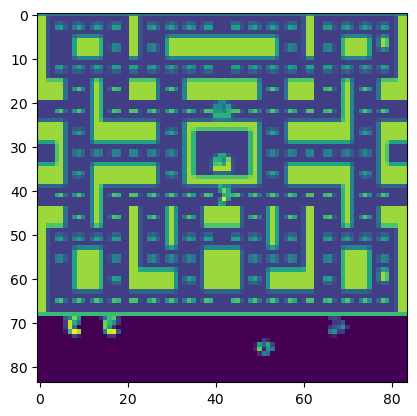

In [15]:
plt.imshow(start[0])
plt.show()

In [16]:
state, _, _, _ = env.step(0)

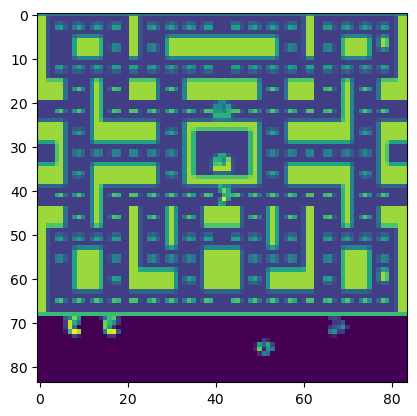

In [17]:
plt.imshow(state[0])
plt.show()

### DQN

In [18]:
class DQN(nn.Module):
    """
    Red Profunda de Aprendizaje Q (Deep Q Network).
    """
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1,*shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)      

In [19]:
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
net

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)

### Experience Replay

In [20]:
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'next_state'])

class ExperienceReplay:
    """
    Almacena experiencias pasadas que han sido observadas por el agente.
    Las muestras obtenidas sirven para entrenar la red, buscando minimizar el efecto que tiene la correlación entre pasos.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def __len__(self):
        return len(self.buffer)
    
    def append(self, *args):
        self.buffer.append(Experience(*args))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

### Agent

In [21]:
class Agent:
    """
     
    """
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()
        
    def _reset(self):
        self.state = self.env.reset()
        self.total_reward = 0.0
        
    def play_step(self, net, epsilon=0.0, device='cuda'):
        done_reward = None
        
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1) # Devuelve el índice de la acción
            action = int(act_v.item())
        
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward

        self.exp_buffer.append(self.state, action, reward, done, new_state)
        self.state = new_state
        
        if done:
            done_reward = self.total_reward
            self._reset()
        
        return done_reward

### Función de entrenamiento

In [22]:
def training(env_name, replay_memory_size=1_000_000, max_frames=50_000_000, gamma=0.99, batch_size=32,  \
             learning_rate=0.00025, momentum=0.95, min_gradient=0.1, sync_target_frames=10_000, \
             replay_start_size=50_000, eps_start=1, eps_min=0.1, seed=2109, device='cuda', verbose=True):
    """
    Función de entrenamiento.
    """
    path = "dicts/" + env_name 
    Path(path).mkdir(parents=True, exist_ok=True)
    
    env = make_atari(env_name)
    buffer = ExperienceReplay(replay_memory_size)
    agent = Agent(env, buffer)
    set_seed(seed=seed, env=env)
    
    net        = DQN(env.observation_space.shape, env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    writer = SummaryWriter(comment='-' + env_name)
    
    epsilon = eps_start
    eps_decay = (eps_start - eps_min) / replay_memory_size
    
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, momentum=momentum, eps=min_gradient)
    total_rewards = []
    
    best_mean_reward = None
    start_time = datetime.datetime.now()
    
    for frame in tqdm(range(1, max_frames+1)):
        epsilon = max(epsilon-eps_decay, eps_min)
        
        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])
            
            time_passed = datetime.datetime.now() - start_time
            
            #writer.add_scalar("epsilon", epsilon, frame)
            writer.add_scalar("reward_100", mean_reward, frame)
            writer.add_scalar("reward", reward, frame)
            
            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), path + "/" + env_name + "_best.dat")
                best_mean_reward = mean_reward
                
        if len(buffer) < replay_start_size:
            continue
            
        sardn = buffer.sample(batch_size)
        batch = Experience(*zip(*sardn))
        
        states_v = torch.tensor(np.array(batch.state)).to(device)
        next_states_v = torch.tensor(np.array(batch.next_state)).to(device)
        actions_v = torch.tensor(batch.action).to(device)
        rewards_v = torch.tensor(batch.reward).to(device)
        done_mask = torch.BoolTensor(batch.done).to(device)
        
        state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
        next_state_values = target_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()
        expected_state_action_values = next_state_values*gamma + rewards_v
        
        loss_t = nn.MSELoss()(state_action_values, expected_state_action_values) # MSELoss()(input,target)
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        if (frame + 1) % sync_target_frames == 0:
            target_net.load_state_dict(net.state_dict())

        if (frame + 1) % (max_frames / 50) == 0:
            if verbose:
                print("{}:  {} games, mean reward {:.3f}, eps {:.2f}, time {}".format(
                    frame + 1, len(total_rewards), mean_reward, epsilon, time_passed))
            torch.save(net.state_dict(), path + "/" + env_name + "_" + str((frame+1)/(max_frames/50)) + ".dat")

    print("Training finished")
    print("{}:  {} games, mean reward {:.3f}, eps {:.2f}, time {}".format(
            frame + 1, len(total_rewards), mean_reward, epsilon, time_passed))
         
    writer.close()
    
    return total_rewards

### TRAINING

In [23]:
GAME_NAME = "MsPacmanNoFrameskip-v4"

In [ ]:
pacman = training(env_name=GAME_NAME)

  0%|                                                                    | 26621/50000000 [00:26<12:08:49, 1142.79it/s]

In [ ]:
pacman